In [1]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn import metrics

In [2]:
cleaned_data = pd.read_csv("D:/4th_SEMESTER/5._DMT/J-Comp/cleaned_data3.csv")

In [3]:
cleaned_data.head(5)

,reviewerID,reviewText,clean_reviewText,clean_summary,rating_class
0,A3LDPF5FMB782Z,The Nook tablet is a great color e-reader with...,tablet great color e-reader bonus able read em...,great color e-reader extra feature,good
1,A2AEZQ3DGBBLPR,I bought this repair kit so I could watch a re...,repair kit could watch movie quite scratch ski...,create new scratch didn fix old ones,bad
2,ATY86XH2DJ4ZH,"I am not an audiophile, but I do care about th...",not audiophile care sound hear headset last we...,not really noise cancel headset,bad
3,A2ATP6ZTCPX1QX,I'm not one to complain much but I hate old pr...,not one complain much hate old products mix ne...,take old products .,bad
4,A3QPWNKTUC8N2B,I bought this ereader and the Amazon Kindle er...,ereader amazon kindle ereader time could compa...,favorite ereader,good


In [4]:
cleaned_data["rating_class"] = cleaned_data["rating_class"].apply(lambda x: 1 if x=="good" else 0)

In [5]:
cleaned_data.head(5)

,reviewerID,reviewText,clean_reviewText,clean_summary,rating_class
0,A3LDPF5FMB782Z,The Nook tablet is a great color e-reader with...,tablet great color e-reader bonus able read em...,great color e-reader extra feature,1
1,A2AEZQ3DGBBLPR,I bought this repair kit so I could watch a re...,repair kit could watch movie quite scratch ski...,create new scratch didn fix old ones,0
2,ATY86XH2DJ4ZH,"I am not an audiophile, but I do care about th...",not audiophile care sound hear headset last we...,not really noise cancel headset,0
3,A2ATP6ZTCPX1QX,I'm not one to complain much but I hate old pr...,not one complain much hate old products mix ne...,take old products .,0
4,A3QPWNKTUC8N2B,I bought this ereader and the Amazon Kindle er...,ereader amazon kindle ereader time could compa...,favorite ereader,1


In [6]:
Y = cleaned_data["rating_class"]
X = cleaned_data["clean_reviewText"]

In [7]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 3))
X_tfidf = tfidf_vect.fit_transform(X.values.astype("U"))
X_tfidf  = X_tfidf.toarray()

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selectK = SelectKBest(f_classif, k=1000)
selectK.fit(X_tfidf, Y)
X_sel = selectK.transform(X_tfidf)

In [9]:
tfidf_vect_train, tfidf_vect_test, Y_train, Y_test = train_test_split(X_sel, Y, test_size=0.2, random_state=42,shuffle=True, stratify = Y)

In [10]:
model = xgb.XGBClassifier(objective = 'binary:logistic',feature_selector= 'thrifty',top_k = '600',n_estimators=100, learning_rate =0.20, max_depth = 30,min_child_weight= 5,gamma = 0.5,colsample_bytree = 0.4)
t0 = time.time()
eval_s = [(tfidf_vect_train, Y_train), (tfidf_vect_test, Y_test)]
model.fit(tfidf_vect_train, Y_train, eval_metric=["aucpr","error"], verbose=True, eval_set = eval_s, early_stopping_rounds=20)
t1 = time.time()
xg_Ypred = model.predict(tfidf_vect_test)
t2 = time.time()
xg_time_linear_train = t1-t0
xg_time_linear_predict = t2-t1
xg_f1Score = f1_score(Y_test, xg_Ypred, average = "weighted")

C:\Users\Acer\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Acer\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13:27:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "feature_selector", "top_k" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.83510	validation_0-error:0.25000	validation_1-aucpr:0.67662	validation_1-error:0.37000
[1]	validation_0-aucpr:0.87495	validation_0-error:0.21750	validation_1-aucpr:0.68103	validation_1-error:0.33500
[2]	validation_0-aucpr:0.90410	validation_0-error:0.18125	validation_1-aucpr:0.74417	validation_1-error:0.31500
[3]	validation_0-aucpr:0.91533	validation_0-error:0.17625	validation_1-aucpr:0.77476	validation_1-error:0.33000
[4]	validation_0-aucpr:0.92209	validation_0-error:0.16000	validation_1-aucpr:0.81028	validation_1-error:0.30000
[5]	va

In [11]:
print("Training time: %fs; Prediction time: %fs" % (xg_time_linear_train, xg_time_linear_predict))

Training time: 1.306629s; Prediction time: 0.013963s


<AxesSubplot:>

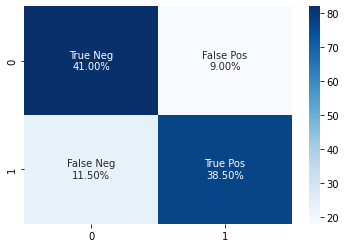

In [12]:
import seaborn as sns
import numpy as np 

cf_matrix = metrics.confusion_matrix(Y_test, xg_Ypred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ['{0:0.0f}'.format(value) for value in
#                 cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v3}" for v1, v3 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [13]:
xg_f1Score

0.7948717948717949

In [14]:
model = CatBoostClassifier(iterations=300, learning_rate=0.1, max_depth = 8)
t0 = time.time()
model.fit(tfidf_vect_train, Y_train)
t1 = time.time()
cat_Ypred = model.predict(tfidf_vect_test)
t2 = time.time()
cat_time_linear_train = t1-t0
cat_time_linear_predict = t2-t1
cat_f1Score = f1_score(Y_test, cat_Ypred, average = "weighted")

0:	learn: 0.6717023	total: 174ms	remaining: 52.2s
1:	learn: 0.6434781	total: 194ms	remaining: 29s
2:	learn: 0.6209286	total: 214ms	remaining: 21.2s
3:	learn: 0.6011621	total: 234ms	remaining: 17.3s
4:	learn: 0.5821043	total: 253ms	remaining: 14.9s
5:	learn: 0.5701937	total: 273ms	remaining: 13.4s
6:	learn: 0.5494151	total: 295ms	remaining: 12.3s
7:	learn: 0.5350778	total: 315ms	remaining: 11.5s
8:	learn: 0.5174455	total: 334ms	remaining: 10.8s
9:	learn: 0.5043019	total: 354ms	remaining: 10.3s
10:	learn: 0.4922540	total: 375ms	remaining: 9.85s
11:	learn: 0.4840741	total: 394ms	remaining: 9.46s
12:	learn: 0.4755271	total: 413ms	remaining: 9.13s
13:	learn: 0.4675709	total: 432ms	remaining: 8.83s
14:	learn: 0.4617732	total: 453ms	remaining: 8.61s
15:	learn: 0.4556566	total: 475ms	remaining: 8.43s
16:	learn: 0.4504852	total: 495ms	remaining: 8.25s
17:	learn: 0.4437985	total: 516ms	remaining: 8.08s
18:	learn: 0.4359126	total: 536ms	remaining: 7.93s
19:	learn: 0.4296365	total: 556ms	remaining

161:	learn: 0.0931083	total: 3.36s	remaining: 2.86s
162:	learn: 0.0927532	total: 3.38s	remaining: 2.84s
163:	learn: 0.0914172	total: 3.4s	remaining: 2.82s
164:	learn: 0.0909928	total: 3.42s	remaining: 2.8s
165:	learn: 0.0907526	total: 3.44s	remaining: 2.77s
166:	learn: 0.0901862	total: 3.46s	remaining: 2.75s
167:	learn: 0.0898593	total: 3.48s	remaining: 2.73s
168:	learn: 0.0885972	total: 3.5s	remaining: 2.71s
169:	learn: 0.0876785	total: 3.51s	remaining: 2.69s
170:	learn: 0.0875271	total: 3.53s	remaining: 2.66s
171:	learn: 0.0865455	total: 3.55s	remaining: 2.64s
172:	learn: 0.0856319	total: 3.57s	remaining: 2.62s
173:	learn: 0.0846144	total: 3.59s	remaining: 2.6s
174:	learn: 0.0836113	total: 3.61s	remaining: 2.58s
175:	learn: 0.0834514	total: 3.63s	remaining: 2.56s
176:	learn: 0.0831386	total: 3.65s	remaining: 2.54s
177:	learn: 0.0823340	total: 3.67s	remaining: 2.52s
178:	learn: 0.0818081	total: 3.69s	remaining: 2.49s
179:	learn: 0.0806791	total: 3.71s	remaining: 2.47s
180:	learn: 0.08

In [15]:
print("Training time: %fs; Prediction time: %fs" % (cat_time_linear_train, cat_time_linear_predict))

Training time: 7.673398s; Prediction time: 0.039926s


<AxesSubplot:>

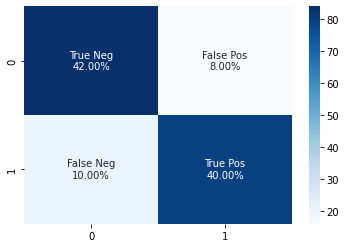

In [16]:
cf_matrix = metrics.confusion_matrix(Y_test, cat_Ypred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ['{0:0.0f}'.format(value) for value in
#                 cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v3}" for v1, v3 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [17]:
cat_f1Score

0.8199279711884754

In [18]:
model = svm.SVC(C = 10)
t0 = time.time()
model.fit(tfidf_vect_train, Y_train)
t1 = time.time()
svc_Ypred = model.predict(tfidf_vect_test)
t2 = time.time()
svc_time_linear_train = t1-t0
svc_time_linear_predict = t2-t1
svc_f1Score = f1_score(Y_test, svc_Ypred, average = "weighted")

In [19]:
print("Training time: %fs; Prediction time: %fs" % (svc_time_linear_train, svc_time_linear_predict))

Training time: 0.198468s; Prediction time: 0.063861s


In [20]:
svc_f1Score

0.8849971249281232

<AxesSubplot:>

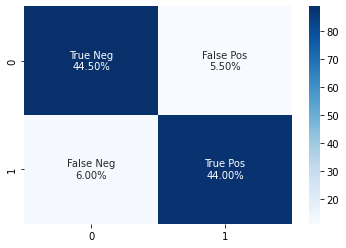

In [21]:
cf_matrix = metrics.confusion_matrix(Y_test, svc_Ypred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ['{0:0.0f}'.format(value) for value in
#                 cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v3}" for v1, v3 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [22]:
f1_scores = [svc_f1Score, cat_f1Score, xg_f1Score]
train_time = [svc_time_linear_train, cat_time_linear_train, xg_time_linear_train]
predict_time = [svc_time_linear_predict, cat_time_linear_predict, xg_time_linear_predict]
algo_name = ["SVC", "CatBoost", "XGBoost"]

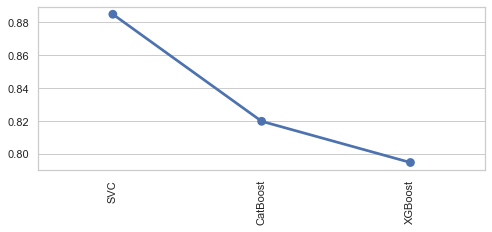

In [23]:
f1_scores = [svc_f1Score, cat_f1Score, xg_f1Score]
train_time = [svc_time_linear_train, cat_time_linear_train, xg_time_linear_train]
predict_time = [svc_time_linear_predict, cat_time_linear_predict, xg_time_linear_predict]
algo_name = ["SVC", "CatBoost", "XGBoost"]

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
sns.set_theme(style = "whitegrid")
ax = sns.pointplot(x = algo_name, y = f1_scores)
ax.set_xticklabels(ax.get_xticklabels() , rotation = 90)
plt.show()

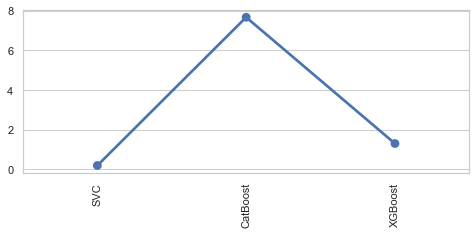

In [24]:
plt.figure(figsize=(8,3))
sns.set_theme(style = "whitegrid")
bx = sns.pointplot(x = algo_name, y = train_time)
bx.set_xticklabels(ax.get_xticklabels() , rotation = 90)
plt.show()

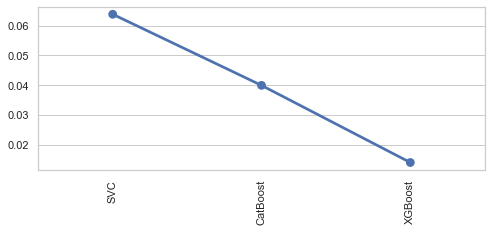

In [25]:
plt.figure(figsize=(8,3))
sns.set_theme(style = "whitegrid")
cx = sns.pointplot(x = algo_name, y = predict_time)
cx.set_xticklabels(ax.get_xticklabels() , rotation = 90)
plt.show()